# GRU

In [10]:
import numpy as np
import torch as t
from torch import nn, optim
import torch.nn.functional as F

In [11]:
import sys
sys.path.append("../input/")
import d2l_jay9460 as d2l
device = t.device('cuda' if t.cuda.is_available() else 'cpu')

(corpus_indices, char_to_idx, idx_to_char, vocab_size) = d2l.load_data_jay_lyrics()

### 初始化参数

In [19]:
num_inputs, num_hiddens, num_outputs = vocab_size, 256, vocab_size
print('will use', device)

def get_params():  
    def _one(shape):
        ts = t.tensor(np.random.normal(0, 0.01, size=shape), device=device, dtype=t.float32) #正态分布
        return nn.Parameter(ts)
    def _three():
        return (_one((num_inputs, num_hiddens)),
                _one((num_hiddens, num_hiddens)),
                nn.Parameter(torch.zeros((1,num_hiddens), device=device, dtype=t.float32)))
     
    W_xz, W_hz, b_z = _three()  # 更新门参数
    W_xr, W_hr, b_r = _three()  # 重置门参数
    W_xh, W_hh, b_h = _three()  # 候选隐藏状态参数
    
    # 输出层参数
    W_hq = _one((num_hiddens, num_outputs))
    b_q = nn.Parameter(t.zeros((1,num_outputs), device=device, dtype=t.float32))
    return nn.ParameterList([W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q])

def init_gru_state(batch_size, num_hiddens, device):   #隐藏状态初始化
    return (t.zeros((batch_size, num_hiddens), device=device), )

will use cpu


### GRU模型

In [13]:
def gru(inputs, state, params):
    W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        Z = t.sigmoid(t.mm(X, W_xz) +t.mm(H, W_hz) + b_z)
        R = t.sigmoid(t.mm(X, W_xr) + t.mm(H, W_hr) + b_r)
        H_tilda = t.tanh(t.mm(X, W_xh) + t.mm(R * H, W_hh) + b_h)
        H = Z * H + (1 - Z) * H_tilda
        Y = t.mm(H, W_hq) + b_q
        outputs.append(Y)
    return outputs, (H,)

### 训练模型

In [14]:
num_epochs, num_steps, batch_size, lr, clipping_theta = 160, 35, 32, 1e2, 1e-2
pred_period, pred_len, prefixes = 40, 50, ['分开', '不分开']

In [15]:
d2l.train_and_predict_rnn(gru, get_params, init_gru_state, num_hiddens,
                          vocab_size, device, corpus_indices, idx_to_char,
                          char_to_idx, False, num_epochs, num_steps, lr,
                          clipping_theta, batch_size, pred_period, pred_len,
                          prefixes)

epoch 40, perplexity 151.355240, time 0.93 sec
 - 分开 我想你的让我不想想想想想想想想想想想想想想想想想想想想想想想想想想想想想想想想想想想想想想想想想想
 - 不分开 我想你的让我不想想想想想想想想想想想想想想想想想想想想想想想想想想想想想想想想想想想想想想想想想想
epoch 80, perplexity 32.385475, time 0.94 sec
 - 分开 我想要这样的怒笑 一定好起 你在我抬多 你爱在人人  没有你有 我有就这样 我有就这样 我不要这样
 - 不分开 你在我遇多 你爱我不多 你爱我 别你的我面 你说 你想我 这样的节笑 我想想这样 我不要再想 我不
epoch 120, perplexity 5.855763, time 0.98 sec
 - 分开 我想就这样牵着你的手不放开 爱可不可以简简单单没有伤害 你 靠着我的肩膀 你 在我胸口睡著 像这样
 - 不分开 不知不觉 我跟了这节奏 后知后觉 又过了一个秋 后知后觉 我该好好生活 我该好好生活 我该好好生活
epoch 160, perplexity 1.765241, time 1.05 sec
 - 分开 我想大声宣坦堡在一起 融到在宇宙里 我每天每天每天在想想想想著你 这样的甜蜜 让我开始乡相信命运 
 - 不分开 不知不觉 你已经离开我 不知不觉 我跟了这节奏 后知后觉 又过了一个秋 后知后觉 我该好好生活 我


### 简洁实现

In [16]:
num_hiddens=256
num_epochs, num_steps, batch_size, lr, clipping_theta = 160, 35, 32, 1e2, 1e-2
pred_period, pred_len, prefixes = 40, 50, ['分开', '不分开']

lr = 1e-2 # 注意调整学习率
gru_layer = nn.GRU(input_size=vocab_size, hidden_size=num_hiddens)
model = d2l.RNNModel(gru_layer, vocab_size).to(device)
d2l.train_and_predict_rnn_pytorch(model, num_hiddens, vocab_size, device,
                                corpus_indices, idx_to_char, char_to_idx,
                                num_epochs, num_steps, lr, clipping_theta,
                                batch_size, pred_period, pred_len, prefixes)

epoch 40, perplexity 1.021275, time 0.62 sec
 - 分开手的话像语言暴力 我已无能为力再提起 决定中断熟悉 然后在这里 不限日期 然后将过去 慢慢温习 让我
 - 不分开暴风圈来不及逃 我不能再想 我不能再想 我不 我不 我不能 爱情走的太快就像龙卷风 不能承受我已无处
epoch 80, perplexity 1.014101, time 0.63 sec
 - 分开的你爱女人 坏坏的让我疯狂的可爱女人 漂亮的让我面红的可爱女人 温柔的让我心疼的可爱女人 透明的让我
 - 不分开的玩笑 想通 却又再考倒我 说散 你想很久了吧? 败给你的黑色幽默 说散 你想很久了吧? 我的认真败
epoch 120, perplexity 1.038854, time 0.74 sec
 - 分开的模样 像无法被安排的雨 随时准备来袭 我怀念起国小的课桌椅 怀念著用铅笔写日记   纪录那最原始的
 - 不分开的模样 可以让我连一看着我的肩膀 你 在我胸口睡著 像这样的生活 我爱你 你爱我 我想大声宣布 对你
epoch 160, perplexity 1.010854, time 0.65 sec
 - 分开的模样 还有在你身上香香的味道 我的快乐是你 想你想的都会笑 没有你在 我有多难熬  没有你在我有多
 - 不分开的玩笑 想通 却又再考倒我 说散 你想很久了吧? 败给你的黑色幽默 说散 你想很久了吧? 我的认真败


# LSTM

### 初始化参数

In [20]:
num_inputs, num_hiddens, num_outputs = vocab_size, 256, vocab_size
print('will use', device)

def get_params():
    def _one(shape):
        ts = t.tensor(np.random.normal(0, 0.01, size=shape), device=device, dtype=t.float32)
        return torch.nn.Parameter(ts)
    def _three():
        return (_one((num_inputs, num_hiddens)),
                _one((num_hiddens, num_hiddens)),
                torch.nn.Parameter(t.zeros((1,num_hiddens), device=device, dtype=t.float32)))
    
    W_xi, W_hi, b_i = _three()  # 输入门参数
    W_xf, W_hf, b_f = _three()  # 遗忘门参数
    W_xo, W_ho, b_o = _three()  # 输出门参数
    W_xc, W_hc, b_c = _three()  # 候选记忆细胞参数
    
    # 输出层参数
    W_hq = _one((num_hiddens, num_outputs))
    b_q = nn.Parameter(t.zeros((1,num_outputs), device=device, dtype=t.float32))
    return nn.ParameterList([W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c, W_hq, b_q])

def init_lstm_state(batch_size, num_hiddens, device):
    return (t.zeros((batch_size, num_hiddens), device=device), 
            t.zeros((batch_size, num_hiddens), device=device))

will use cpu


### LSTM模型

In [21]:
def lstm(inputs, state, params):
    [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c, W_hq, b_q] = params
    (H, C) = state
    outputs = []
    for X in inputs:
        I = t.sigmoid(t.mm(X, W_xi) + t.mm(H, W_hi) + b_i)
        F = t.sigmoid(t.mm(X, W_xf) + t.mm(H, W_hf) + b_f)
        O = t.sigmoid(t.mm(X, W_xo) + t.mm(H, W_ho) + b_o)
        C_tilda = t.tanh(t.mm(X, W_xc) + t.mm(H, W_hc) + b_c)
        C = F * C + I * C_tilda
        H = O * C.tanh()
        Y = t.mm(H, W_hq) + b_q
        outputs.append(Y)
    return outputs, (H, C)

### 训练模型

In [22]:
num_epochs, num_steps, batch_size, lr, clipping_theta = 160, 35, 32, 1e2, 1e-2
pred_period, pred_len, prefixes = 40, 50, ['分开', '不分开']

d2l.train_and_predict_rnn(lstm, get_params, init_lstm_state, num_hiddens,
                          vocab_size, device, corpus_indices, idx_to_char,
                          char_to_idx, False, num_epochs, num_steps, lr,
                          clipping_theta, batch_size, pred_period, pred_len,
                          prefixes)

epoch 40, perplexity 213.529415, time 1.18 sec
 - 分开 我不不 我不你 我不你的我 我不不 我不你的我 我不不 我不你的我 我不不 我不你的我 我不不 我
 - 不分开 我不不 我不你 我不你的我 我不不 我不你的我 我不不 我不你的我 我不不 我不你的我 我不不 我
epoch 80, perplexity 66.901248, time 1.19 sec
 - 分开 我想你这你我想你 我想你你的你我 你不 我想想想你我 我不要这样我 我不要这样我 我不要这样我 我
 - 不分开 我想你这你我想你 我想你你的你我 你不 我想想想你我 我不要这样我 我不要这样我 我不要这样我 我
epoch 120, perplexity 15.753898, time 1.12 sec
 - 分开 我想你的话笑笑 一你在 一直我 我想就这样牵着你的手不放开 爱可不可以简简单单没有有害 你   我
 - 不分开 我想你你 我我多难难  有有你的快快我 别发球我 别怪我 我想就这样牵着你的手不放开 爱可不可以简
epoch 160, perplexity 4.033523, time 1.20 sec
 - 分开 我想你的话笑笑听天在我不多  我知道这里 但我妈你乡你命奔 我想能你的你在幽天 想要和你融化在一天
 - 不分开 我已你你你经我妈妈 难道你在不会 让我的你天 我爱能你 我爱能这节奏 后后后觉 我跟了这节奏 后知


### 简洁实现

In [13]:
num_hiddens=256
num_epochs, num_steps, batch_size, lr, clipping_theta = 160, 35, 32, 1e2, 1e-2
pred_period, pred_len, prefixes = 40, 50, ['分开', '不分开']

lr = 1e-2 # 注意调整学习率
lstm_layer = nn.LSTM(input_size=vocab_size, hidden_size=num_hiddens)
model = d2l.RNNModel(lstm_layer, vocab_size)
d2l.train_and_predict_rnn_pytorch(model, num_hiddens, vocab_size, device,
                                corpus_indices, idx_to_char, char_to_idx,
                                num_epochs, num_steps, lr, clipping_theta,
                                batch_size, pred_period, pred_len, prefixes)

epoch 40, perplexity 1.019881, time 1.04 sec
 - 分开始打呼 管家是一只会说法语举止优雅的猪 吸血前会念约翰福音做为弥补 拥有一双蓝色眼睛的凯萨琳公主 专
 - 不分开的玩笑 想通 却又再考倒我 说散 你想很久了吧? 败给你的黑色幽默 不想太多 我想一定是我听错弄错搞
epoch 80, perplexity 1.013078, time 1.01 sec
 - 分开的话像语言暴力 我已无能为力再提起 决定中断熟悉 然后在这里 不限日期 然后将过去 慢慢温习 让我爱
 - 不分开的玩笑 想通 却又再考倒我 说散 你想很久了吧? 败给你的黑色幽默 说散 你想很久了吧? 我的认真败
epoch 120, perplexity 1.010264, time 1.01 sec
 - 分开 我们儿子她人在江南等我 泪不休 语沉默 一壶好酒 再来一碗热粥 配上几斤的牛肉 我说店小二 三两银
 - 不分开 我有你看棒球 想这样没担忧 唱着歌 一直走 我想就这样牵着你的手不放开 爱可不可以简简单单没有伤害
epoch 160, perplexity 1.008950, time 1.02 sec
 - 分开 我才  原来我只想要你 陪我去吃汉堡  说穿了其实我的愿望就怎么小 就怎么每天祈祷我的心跳你知道 
 - 不分开 我才你看 我想要再这样打我妈妈 我说的话 你甘会听 不要再这样打我妈妈 难道你手不会痛吗 其实我回


# 深度循环神经网络  
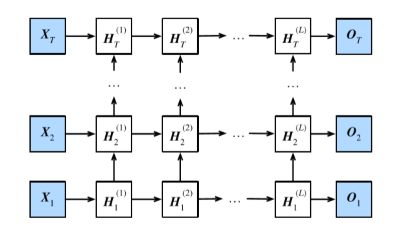

In [23]:


num_hiddens=256
num_epochs, num_steps, batch_size, lr, clipping_theta = 160, 35, 32, 1e2, 1e-2
pred_period, pred_len, prefixes = 40, 50, ['分开', '不分开']

lr = 1e-2 # 注意调整学习率

gru_layer = nn.LSTM(input_size=vocab_size, hidden_size=num_hiddens,num_layers=2)#改变num_layers增加层数
model = d2l.RNNModel(gru_layer, vocab_size).to(device)
d2l.train_and_predict_rnn_pytorch(model, num_hiddens, vocab_size, device,
                                corpus_indices, idx_to_char, char_to_idx,
                                num_epochs, num_steps, lr, clipping_theta,
                                batch_size, pred_period, pred_len, prefixes)

epoch 40, perplexity 8.719939, time 1.11 sec
 - 分开 不要么这样打有想有 我想要你 说不这样牵着我 别爱么 我想你 我不要再这样打看妈去 我知道么我不多
 - 不分开不想有 我想要你 说不这样牵着我 别爱么 我想你 我不要再这样打看妈去 我知道么我不多 我不想你 我
epoch 80, perplexity 1.071851, time 1.24 sec
 - 分开的话我你 说不着我不想 我的 你不想活 说你怎么面对我 甩开球我满腔的怒火 我想揍你已经很久 别想躲
 - 不分开 这样我一只画面的语土  离不了这里头  爱上了什么 我变得很主动 若爱上一个人 什么都会值得去做 
epoch 120, perplexity 1.018716, time 1.14 sec
 - 分开 你们在你痛 我想了这样牵着你的手不放开 爱能不能够永远单纯没有悲哀 我 想带你骑单车 我 想和你看
 - 不分开 这样的甜蜜 让我开始乡相信命运 感谢地心引力 让我碰到你 漂亮的让我面红的可爱女人 温柔的让我心疼
epoch 160, perplexity 1.016621, time 1.14 sec
 - 分开 你们在你痛 我想大声宣布 对你依依不舍 连隔壁邻居都猜到我现在的感受 河边的风 在吹着头发飘动 牵
 - 不分开 说穿了其实我的愿望就怎么小 就怎么每天祈祷我的心跳你知道  杵在伊斯坦堡 却只想你和汉堡 我想要你


In [15]:
gru_layer = nn.LSTM(input_size=vocab_size, hidden_size=num_hiddens,num_layers=6)
model = d2l.RNNModel(gru_layer, vocab_size).to(device)
d2l.train_and_predict_rnn_pytorch(model, num_hiddens, vocab_size, device,
                                corpus_indices, idx_to_char, char_to_idx,
                                num_epochs, num_steps, lr, clipping_theta,
                                batch_size, pred_period, pred_len, prefixes)

epoch 80, perplexity 281.847074, time 19.94 sec
 - 分开                                                  
 - 不分开                                                  
epoch 120, perplexity 281.551241, time 20.62 sec
 - 分开                                                  
 - 不分开                                                  


# 双向循环神经网络 
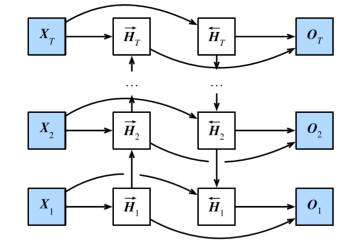

In [16]:
num_hiddens=128
num_epochs, num_steps, batch_size, lr, clipping_theta = 160, 35, 32, 1e-2, 1e-2
pred_period, pred_len, prefixes = 40, 50, ['分开', '不分开']

lr = 1e-2 # 注意调整学习率

gru_layer = nn.GRU(input_size=vocab_size, hidden_size=num_hiddens,bidirectional=True)#bidirectional=True使用双向
model = d2l.RNNModel(gru_layer, vocab_size).to(device)
d2l.train_and_predict_rnn_pytorch(model, num_hiddens, vocab_size, device,
                                corpus_indices, idx_to_char, char_to_idx,
                                num_epochs, num_steps, lr, clipping_theta,
                                batch_size, pred_period, pred_len, prefixes)